In [85]:
#!pip install wandb

     |████████████████████████████████| 1.8 MB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 181 kB 46.1 MB/s eta 0:00:01
     |████████████████████████████████| 281 kB 38.0 MB/s eta 0:00:01
     |████████████████████████████████| 145 kB 44.3 MB/s eta 0:00:01
     |████████████████████████████████| 661 kB 42.7 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 3.1 MB/s  eta 0:00:01
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8784 sha256=197f4f2e2da630d86c5160a310be5d4fe4f865048710162412d2451b6f7a0bc4
  Stored in directory: /home/sawant_shriraj/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [1]:
from wandb import magic

wandb: Currently logged in as: shri13. Use `wandb login --relogin` to force relogin


2022-06-28 06:43:52.867890: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Overcoming Catastrophic Forgetting

https://arxiv.org/abs/1612.00796

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import Regularizer

tf.compat.v1.disable_eager_execution()

def computer_fisher(model, imgset, num_sample=30):
    f_accum = []
    for i in range(len(model.weights)):
        f_accum.append(np.zeros(K.int_shape(model.weights[i])))
    f_accum = np.array(f_accum)
    for j in range(num_sample):
        img_index = np.random.randint(imgset.shape[0])
        for m in range(len(model.weights)):                           
            grads = K.gradients(K.log(model.output), model.weights)[m]
            result = K.function([model.input], [grads])
            f_accum[m] += np.square(result([np.expand_dims(imgset[img_index], 0)])[0])
    f_accum /= num_sample
    return f_accum


class ewc_reg(Regularizer):
    def __init__(self, fisher, prior_weights, Lambda=0.1):
        self.fisher = fisher
        self.prior_weights = prior_weights
        self.Lambda = Lambda

    def __call__(self, x):
        regularization = 0.
        regularization += self.Lambda * K.sum(self.fisher * K.square(x - self.prior_weights))
        return regularization

    def get_config(self):
        return {'Lambda': float(self.Lambda)}

2024-05-17 19:03:45.802696: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


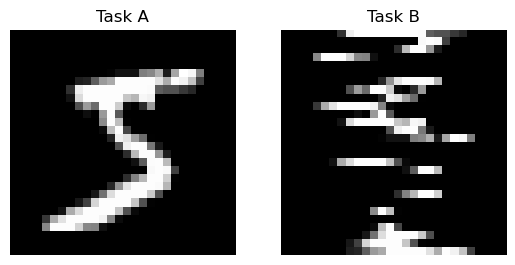

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# Random pixel permutation for Task B
ind = np.arange(x_train.shape[1])
np.random.shuffle(ind)
x_train1 = x_train[:, ind]
x_test1 = x_test[:, ind]
y_train1 = y_train
y_test1 = y_test

# Display three Tasks Dataset images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(x_train[0].reshape((28, 28)), cmap='gray')
plt.title('Task A')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_train1[0].reshape((28, 28)), cmap='gray')
plt.title('Task B')
plt.axis('off')
plt.show()



In [4]:
num_classes = 10
input_shape = (28, 28, 1)

In [5]:
# Task A training and save the prior weights for the next Task
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, 100, 10, validation_data=(x_test, y_test))
model.save('MNISTcnnA.h5')


2024-05-17 19:04:22.934729: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-05-17 19:04:22.935733: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-05-17 19:04:23.013733: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.74GiB deviceMemoryBandwidth: 417.29GiB/s
2024-05-17 19:04:23.013783: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-05-17 19:04:23.015408: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-05-17 19:04:23.015478: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2024-

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

2024-05-17 19:04:23.586021: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-05-17 19:04:23.586051: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      0 
2024-05-17 19:04:23.586055: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 0:   N 
2024-05-17 19:04:23.587376: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1406] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 13034 MB memory) -> physical GPU (device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5)
2024-05-17 19:04:23.597329: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2024-05-17 19:04:23.603088: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz


Epoch 1/10


2024-05-17 19:04:23.818110: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-05-17 19:04:23.959132: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


59000/60000 [============================>.] - ETA: 0s - loss: 0.3097 - accuracy: 0.9076

/home/shriraj/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 3s 56us/sample - loss: 0.3066 - accuracy: 0.9083 - val_loss: 0.0798 - val_accuracy: 0.9753
Epoch 2/10
60000/60000 [==============================] - 2s 35us/sample - loss: 0.0974 - accuracy: 0.9708 - val_loss: 0.0492 - val_accuracy: 0.9840
Epoch 3/10
60000/60000 [==============================] - 2s 34us/sample - loss: 0.0742 - accuracy: 0.9778 - val_loss: 0.0396 - val_accuracy: 0.9860
Epoch 4/10
60000/60000 [==============================] - 2s 35us/sample - loss: 0.0615 - accuracy: 0.9812 - val_loss: 0.0350 - val_accuracy: 0.9881
Epoch 5/10
60000/60000 [==============================] - 2s 35us/sample - loss: 0.0545 - accuracy: 0.9835 - val_loss: 0.0346 - val_accuracy: 0.9882
Epoch 6/10
60000/60000 [==============================] - 2s 35us/sample - loss: 0.0502 - accuracy: 0.9847 - val_loss: 0.0284 - val_accuracy: 0.9905
Epoch 7/10
60000/60000 [==============================] - 2s 35us/sample - loss: 0.0461 - accuracy: 0.9857 - val_loss

In [6]:
B_NoP_OG = 100 * model.evaluate(x_test1, y_test1, verbose=0)[1]

In [7]:
B_NoP_OG

13.439999520778656

In [5]:
# Compute the Fisher Information for each parameter in Task A
print('Processing Fisher Information...')
I = computer_fisher(model, x_train)
print('Processing Finish!')

Processing Fisher Information...


/tmp/ipykernel_3729655/410063561.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  f_accum = np.array(f_accum)


Processing Finish!


In [7]:
# Task B EWC training

model_ewcB = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_regularizer=ewc_reg(I[0], model.weights[0]),
                 bias_regularizer=ewc_reg(I[1], model.weights[1])),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", kernel_regularizer=ewc_reg(I[2], model.weights[2]),
                 bias_regularizer=ewc_reg(I[3], model.weights[3])),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax",kernel_regularizer=ewc_reg(I[4], model.weights[4]),
                 bias_regularizer=ewc_reg(I[5], model.weights[5])),
    ]
)
model_ewcB.summary()

model_ewcB.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model_ewcB.load_weights('MNISTA.h5')
model_ewcB.fit(x_train1, y_train1, 100, 10, validation_data=(x_test1, y_test1))



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)               

In [8]:
# Task B no penalty training

model_NoP_B = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model_NoP_B.summary()

model_NoP_B.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model_NoP_B.load_weights('MNISTA.h5')
model_NoP_B.fit(x_train1, y_train1, 100, 10, validation_data=(x_test1, y_test1))



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

In [9]:
# Current Task Performance
B_EWC = 100 * model_ewcB.evaluate(x_test1, y_test1, verbose=0)[1]
B_No_P = 100 * model_NoP_B.evaluate(x_test1, y_test1, verbose=0)[1]
# Previous Task Performance
A_EWC = 100 * model_ewcB.evaluate(x_test, y_test, verbose=0)[1]
A_No_P = 100 * model_NoP_B.evaluate(x_test, y_test, verbose=0)[1]

print("Task A Original Accuracy: %.2f%%" % (100 * model.evaluate(x_test, y_test)[1]))
print("Task B EWC method penalty Accuracy: %.2f%%" % B_EWC)
print("Task B SGD method Accuracy: %.2f%%" % B_No_P)
print("Task A EWC method penalty Accuracy: %.2f%%" % A_EWC)
print("Task A SGD method Accuracy: %.2f%%" % A_No_P)



Task A Original Accuracy: 99.09%
Task B EWC method penalty Accuracy: 92.52%
Task B SGD method Accuracy: 97.87%
Task A EWC method penalty Accuracy: 91.75%
Task A SGD method Accuracy: 22.73%


/tmp/ipykernel_3729655/305336545.py:6: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x, B_EWC, width=width, label='EWC Task B', hatch='w/', ec='w')
/tmp/ipykernel_3729655/305336545.py:7: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x + width, B_No_P, width=width, label='SGD Task B', hatch='w/', ec='w')
/tmp/ipykernel_3729655/305336545.py:8: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x + 3.5 * width, A_EWC, width=w

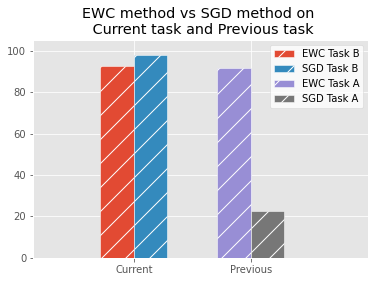

In [10]:
x = 0
total_width, n = 0.1, 2
width = total_width / n
x = x - (total_width - width) / 2
plt.style.use('ggplot')
plt.bar(x, B_EWC, width=width, label='EWC Task B', hatch='w/', ec='w')
plt.bar(x + width, B_No_P, width=width, label='SGD Task B', hatch='w/', ec='w')
plt.bar(x + 3.5 * width, A_EWC, width=width, label='EWC Task A', hatch='w/', ec='w')
plt.bar(x + 4.5 * width, A_No_P, width=width, label='SGD Task A', hatch='w/', ec='w')
plt.legend(facecolor='white')
plt.xticks(np.array([0., 3.5 * width]), ('Current', 'Previous'))
plt.title('EWC method vs SGD method on \n Current task and Previous task')
plt.xlim(-0.15, 0.35)
plt.ylim(0., 105.)
plt.show()

In [ ]:
# swap task A and B

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


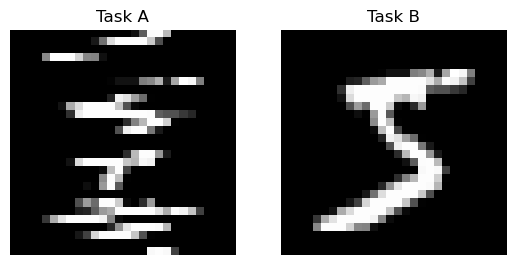

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt

(x_train1, y_train1), (x_test1, y_test1) = mnist.load_data()
# the data, split between train and test sets
(x_train1, y_train1), (x_test1, y_test1) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train1 = x_train1.astype("float32") / 255
x_test1 = x_test1.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train1 = np.expand_dims(x_train1, -1)
x_test1 = np.expand_dims(x_test1, -1)
print("x_train shape:", x_train1.shape)
print(x_train1.shape[0], "train samples")
print(x_test1.shape[0], "test samples")

# Random pixel permutation for Task B
ind = np.arange(x_train1.shape[1])
np.random.shuffle(ind)
x_train = x_train1[:, ind]
x_test = x_test1[:, ind]
y_train = y_train1
y_test = y_test1

# Display three Tasks Dataset images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(x_train[0].reshape((28, 28)), cmap='gray')
plt.title('Task A')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_train1[0].reshape((28, 28)), cmap='gray')
plt.title('Task B')
plt.axis('off')
plt.show()



In [9]:
num_classes = 10
input_shape = (28, 28, 1)

In [11]:
# Task A training and save the prior weights for the next Task
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, 100, 10, validation_data=(x_test, y_test))
model.save('randMNISTcnnA.h5')


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

In [12]:
A_NoP_OG = 100 * model.evaluate(x_test1, y_test1, verbose=0)[1]

In [13]:
A_NoP_OG

28.839999437332153

In [14]:
# Compute the Fisher Information for each parameter in Task A
print('Processing Fisher Information...')
I = computer_fisher(model, x_train)
print('Processing Finish!')

Processing Fisher Information...


/tmp/ipykernel_3729655/410063561.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  f_accum = np.array(f_accum)


Processing Finish!


In [15]:
# Task B EWC training

model_ewcB = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_regularizer=ewc_reg(I[0], model.weights[0]),
                 bias_regularizer=ewc_reg(I[1], model.weights[1])),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", kernel_regularizer=ewc_reg(I[2], model.weights[2]),
                 bias_regularizer=ewc_reg(I[3], model.weights[3])),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax",kernel_regularizer=ewc_reg(I[4], model.weights[4]),
                 bias_regularizer=ewc_reg(I[5], model.weights[5])),
    ]
)
model_ewcB.summary()

model_ewcB.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model_ewcB.load_weights('MNISTA.h5')
model_ewcB.fit(x_train1, y_train1, 100, 10, validation_data=(x_test1, y_test1))



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

In [16]:
# Task B no penalty training

model_NoP_B = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model_NoP_B.summary()

model_NoP_B.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model_NoP_B.load_weights('MNISTA.h5')
model_NoP_B.fit(x_train1, y_train1, 100, 10, validation_data=(x_test1, y_test1))



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

In [17]:
# Current Task Performance
B_EWC = 100 * model_ewcB.evaluate(x_test1, y_test1, verbose=0)[1]
B_No_P = 100 * model_NoP_B.evaluate(x_test1, y_test1, verbose=0)[1]
# Previous Task Performance
A_EWC = 100 * model_ewcB.evaluate(x_test, y_test, verbose=0)[1]
A_No_P = 100 * model_NoP_B.evaluate(x_test, y_test, verbose=0)[1]

print("Task A Original Accuracy: %.2f%%" % (100 * model.evaluate(x_test, y_test)[1]))
print("Task B EWC method penalty Accuracy: %.2f%%" % B_EWC)
print("Task B SGD method Accuracy: %.2f%%" % B_No_P)
print("Task A EWC method penalty Accuracy: %.2f%%" % A_EWC)
print("Task A SGD method Accuracy: %.2f%%" % A_No_P)



Task A Original Accuracy: 97.98%
Task B EWC method penalty Accuracy: 96.28%
Task B SGD method Accuracy: 99.17%
Task A EWC method penalty Accuracy: 76.55%
Task A SGD method Accuracy: 13.96%


/tmp/ipykernel_3729655/305336545.py:6: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x, B_EWC, width=width, label='EWC Task B', hatch='w/', ec='w')
/tmp/ipykernel_3729655/305336545.py:7: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x + width, B_No_P, width=width, label='SGD Task B', hatch='w/', ec='w')
/tmp/ipykernel_3729655/305336545.py:8: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x + 3.5 * width, A_EWC, width=w

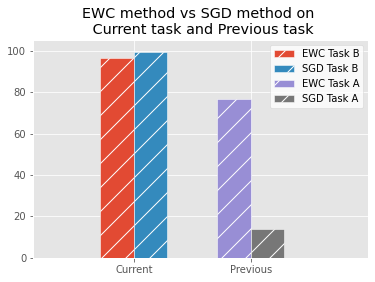

In [18]:
x = 0
total_width, n = 0.1, 2
width = total_width / n
x = x - (total_width - width) / 2
plt.style.use('ggplot')
plt.bar(x, B_EWC, width=width, label='EWC Task B', hatch='w/', ec='w')
plt.bar(x + width, B_No_P, width=width, label='SGD Task B', hatch='w/', ec='w')
plt.bar(x + 3.5 * width, A_EWC, width=width, label='EWC Task A', hatch='w/', ec='w')
plt.bar(x + 4.5 * width, A_No_P, width=width, label='SGD Task A', hatch='w/', ec='w')
plt.legend(facecolor='white')
plt.xticks(np.array([0., 3.5 * width]), ('Current', 'Previous'))
plt.title('EWC method vs SGD method on \n Current task and Previous task')
plt.xlim(-0.15, 0.35)
plt.ylim(0., 105.)
plt.show()

## With mnist first and fmnist as sequential task

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


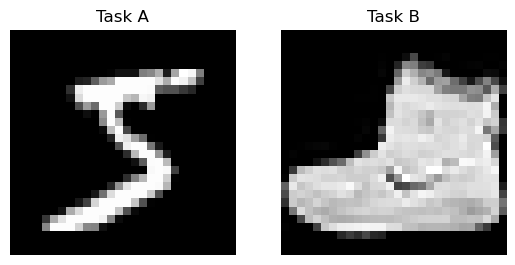

In [14]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


#FMNIST for task B
# the data, split between train and test sets
(x_train1, y_train1), (x_test1, y_test1) = keras.datasets.fashion_mnist.load_data()

# Scale images to the [0, 1] range
x_train1 = x_train1.astype("float32") / 255
x_test1 = x_test1.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train1 = np.expand_dims(x_train1, -1)
x_test1 = np.expand_dims(x_test1, -1)
print("x_train shape:", x_train1.shape)
print(x_train1.shape[0], "train samples")
print(x_test1.shape[0], "test samples")

# Display three Tasks Dataset images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(x_train[0].reshape((28, 28)), cmap='gray')
plt.title('Task A')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_train1[0].reshape((28, 28)), cmap='gray')
plt.title('Task B')
plt.axis('off')
plt.show()



In [15]:
num_classes = 10
input_shape = (28, 28, 1)

In [16]:
# Task A training and save the prior weights for the next Task
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, 100, 10, validation_data=(x_test, y_test))
model.save('MNISTcnnA.h5')


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [17]:
B_NoP_OG = 100 * model.evaluate(x_test1, y_test1, verbose=0)[1]

In [18]:
B_NoP_OG

12.569999694824219

In [22]:
# Compute the Fisher Information for each parameter in Task A
print('Processing Fisher Information...')
I = computer_fisher(model, x_train)
print('Processing Finish!')

Processing Fisher Information...


/tmp/ipykernel_3729655/410063561.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  f_accum = np.array(f_accum)


Processing Finish!


In [23]:
# Task B EWC training

model_ewcB = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_regularizer=ewc_reg(I[0], model.weights[0]),
                 bias_regularizer=ewc_reg(I[1], model.weights[1])),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", kernel_regularizer=ewc_reg(I[2], model.weights[2]),
                 bias_regularizer=ewc_reg(I[3], model.weights[3])),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax",kernel_regularizer=ewc_reg(I[4], model.weights[4]),
                 bias_regularizer=ewc_reg(I[5], model.weights[5])),
    ]
)
model_ewcB.summary()

model_ewcB.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model_ewcB.load_weights('MNISTA.h5')
model_ewcB.fit(x_train1, y_train1, 100, 10, validation_data=(x_test1, y_test1))



Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

In [24]:
# Task B no penalty training

model_NoP_B = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model_NoP_B.summary()

model_NoP_B.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model_NoP_B.load_weights('MNISTA.h5')
model_NoP_B.fit(x_train1, y_train1, 100, 10, validation_data=(x_test1, y_test1))



Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

In [25]:
# Current Task Performance
B_EWC = 100 * model_ewcB.evaluate(x_test1, y_test1, verbose=0)[1]
B_No_P = 100 * model_NoP_B.evaluate(x_test1, y_test1, verbose=0)[1]
# Previous Task Performance
A_EWC = 100 * model_ewcB.evaluate(x_test, y_test, verbose=0)[1]
A_No_P = 100 * model_NoP_B.evaluate(x_test, y_test, verbose=0)[1]

print("Task A Original Accuracy: %.2f%%" % (100 * model.evaluate(x_test, y_test)[1]))
print("Task B EWC method penalty Accuracy: %.2f%%" % B_EWC)
print("Task B SGD method Accuracy: %.2f%%" % B_No_P)
print("Task A EWC method penalty Accuracy: %.2f%%" % A_EWC)
print("Task A SGD method Accuracy: %.2f%%" % A_No_P)



Task A Original Accuracy: 99.06%
Task B EWC method penalty Accuracy: 81.84%
Task B SGD method Accuracy: 90.12%
Task A EWC method penalty Accuracy: 83.51%
Task A SGD method Accuracy: 15.93%


/tmp/ipykernel_3729655/305336545.py:6: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x, B_EWC, width=width, label='EWC Task B', hatch='w/', ec='w')
/tmp/ipykernel_3729655/305336545.py:7: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x + width, B_No_P, width=width, label='SGD Task B', hatch='w/', ec='w')
/tmp/ipykernel_3729655/305336545.py:8: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x + 3.5 * width, A_EWC, width=w

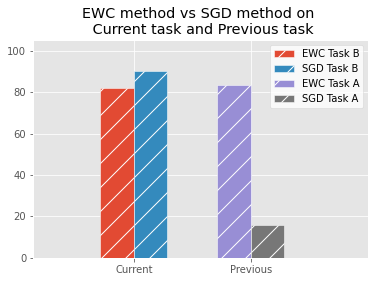

In [26]:
x = 0
total_width, n = 0.1, 2
width = total_width / n
x = x - (total_width - width) / 2
plt.style.use('ggplot')
plt.bar(x, B_EWC, width=width, label='EWC Task B', hatch='w/', ec='w')
plt.bar(x + width, B_No_P, width=width, label='SGD Task B', hatch='w/', ec='w')
plt.bar(x + 3.5 * width, A_EWC, width=width, label='EWC Task A', hatch='w/', ec='w')
plt.bar(x + 4.5 * width, A_No_P, width=width, label='SGD Task A', hatch='w/', ec='w')
plt.legend(facecolor='white')
plt.xticks(np.array([0., 3.5 * width]), ('Current', 'Previous'))
plt.title('EWC method vs SGD method on \n Current task and Previous task')
plt.xlim(-0.15, 0.35)
plt.ylim(0., 105.)
plt.show()

/home/sawant_shriraj/.conda/envs/shri/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


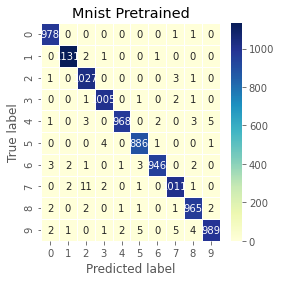

In [27]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = np.argmax(model.predict(x_test, y_test, 100, 1), axis=-1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('Mnist Pretrained')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

/home/sawant_shriraj/.conda/envs/shri/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


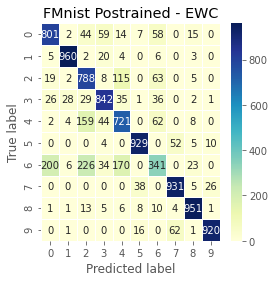

In [28]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = np.argmax(model_ewcB.predict(x_test1, y_test1, 100, 1), axis=-1)
cm = confusion_matrix(y_test1, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('FMnist Postrained - EWC')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

/home/sawant_shriraj/.conda/envs/shri/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


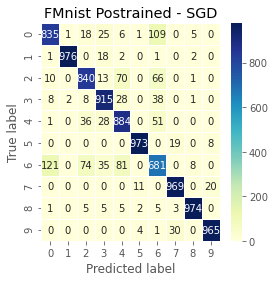

In [29]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = np.argmax( model_NoP_B.predict(x_test1, y_test1, 100, 1), axis=-1)
cm = confusion_matrix(y_test1, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('FMnist Postrained - SGD')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

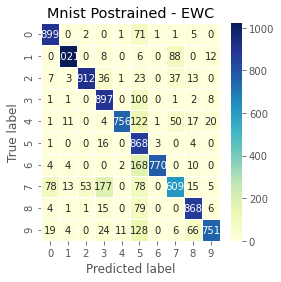

In [30]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = np.argmax(model_ewcB.predict(x_test, y_test, 100, 1), axis=-1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('Mnist Postrained - EWC')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

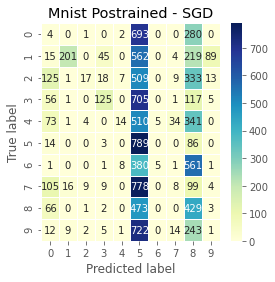

In [31]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = np.argmax( model_NoP_B.predict(x_test, y_test, 100, 1), axis=-1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('Mnist Postrained - SGD')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## With fmnist first and mnist as sequential task

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


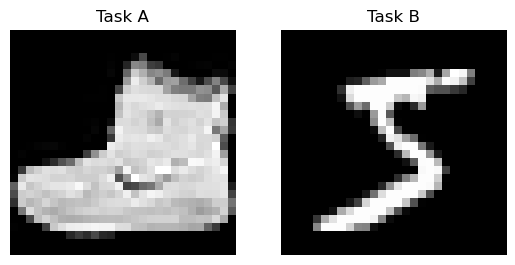

In [19]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


#FMNIST for task B
# the data, split between train and test sets
(x_train1, y_train1), (x_test1, y_test1) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train1 = x_train1.astype("float32") / 255
x_test1 = x_test1.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train1 = np.expand_dims(x_train1, -1)
x_test1 = np.expand_dims(x_test1, -1)
print("x_train shape:", x_train1.shape)
print(x_train1.shape[0], "train samples")
print(x_test1.shape[0], "test samples")

# Display three Tasks Dataset images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(x_train[0].reshape((28, 28)), cmap='gray')
plt.title('Task A')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_train1[0].reshape((28, 28)), cmap='gray')
plt.title('Task B')
plt.axis('off')
plt.show()



In [20]:
num_classes = 10
input_shape = (28, 28, 1)

In [21]:
# Task A training and save the prior weights for the next Task
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, 100, 10, validation_data=(x_test, y_test))
model.save('FMNISTcnnA.h5')


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

In [22]:
A_NoP_OG = 100 * model.evaluate(x_test1, y_test1, verbose=0)[1]

In [23]:
A_NoP_OG 

12.370000034570694

In [35]:
# Compute the Fisher Information for each parameter in Task A
print('Processing Fisher Information...')
I = computer_fisher(model, x_train)
print('Processing Finish!')

Processing Fisher Information...


/tmp/ipykernel_3729655/410063561.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  f_accum = np.array(f_accum)


Processing Finish!


In [36]:
# Task B EWC training

model_ewcB = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_regularizer=ewc_reg(I[0], model.weights[0]),
                 bias_regularizer=ewc_reg(I[1], model.weights[1])),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", kernel_regularizer=ewc_reg(I[2], model.weights[2]),
                 bias_regularizer=ewc_reg(I[3], model.weights[3])),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax",kernel_regularizer=ewc_reg(I[4], model.weights[4]),
                 bias_regularizer=ewc_reg(I[5], model.weights[5])),
    ]
)
model_ewcB.summary()

model_ewcB.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model_ewcB.load_weights('MNISTA.h5')
model_ewcB.fit(x_train1, y_train1, 100, 10, validation_data=(x_test1, y_test1))



Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 1600)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)              

In [37]:
# Task B no penalty training

model_NoP_B = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model_NoP_B.summary()

model_NoP_B.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
model_NoP_B.load_weights('MNISTA.h5')
model_NoP_B.fit(x_train1, y_train1, 100, 10, validation_data=(x_test1, y_test1))



Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 1600)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)              

In [38]:
# Current Task Performance
B_EWC = 100 * model_ewcB.evaluate(x_test1, y_test1, verbose=0)[1]
B_No_P = 100 * model_NoP_B.evaluate(x_test1, y_test1, verbose=0)[1]
# Previous Task Performance
A_EWC = 100 * model_ewcB.evaluate(x_test, y_test, verbose=0)[1]
A_No_P = 100 * model_NoP_B.evaluate(x_test, y_test, verbose=0)[1]

print("Task A Original Accuracy: %.2f%%" % (100 * model.evaluate(x_test, y_test)[1]))
print("Task B EWC method penalty Accuracy: %.2f%%" % B_EWC)
print("Task B SGD method Accuracy: %.2f%%" % B_No_P)
print("Task A EWC method penalty Accuracy: %.2f%%" % A_EWC)
print("Task A SGD method Accuracy: %.2f%%" % A_No_P)



Task A Original Accuracy: 90.17%
Task B EWC method penalty Accuracy: 96.96%
Task B SGD method Accuracy: 99.02%
Task A EWC method penalty Accuracy: 46.64%
Task A SGD method Accuracy: 22.69%


/tmp/ipykernel_3729655/305336545.py:6: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x, B_EWC, width=width, label='EWC Task B', hatch='w/', ec='w')
/tmp/ipykernel_3729655/305336545.py:7: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x + width, B_No_P, width=width, label='SGD Task B', hatch='w/', ec='w')
/tmp/ipykernel_3729655/305336545.py:8: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "w". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  plt.bar(x + 3.5 * width, A_EWC, width=w

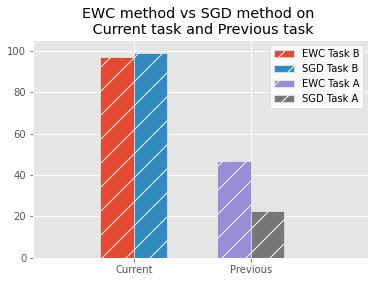

In [39]:
x = 0
total_width, n = 0.1, 2
width = total_width / n
x = x - (total_width - width) / 2
plt.style.use('ggplot')
plt.bar(x, B_EWC, width=width, label='EWC Task B', hatch='w/', ec='w')
plt.bar(x + width, B_No_P, width=width, label='SGD Task B', hatch='w/', ec='w')
plt.bar(x + 3.5 * width, A_EWC, width=width, label='EWC Task A', hatch='w/', ec='w')
plt.bar(x + 4.5 * width, A_No_P, width=width, label='SGD Task A', hatch='w/', ec='w')
plt.legend(facecolor='white')
plt.xticks(np.array([0., 3.5 * width]), ('Current', 'Previous'))
plt.title('EWC method vs SGD method on \n Current task and Previous task')
plt.xlim(-0.15, 0.35)
plt.ylim(0., 105.)
plt.show()

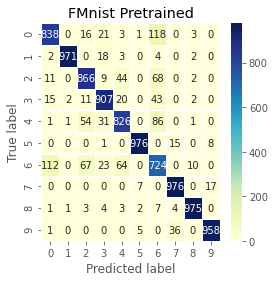

In [45]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = np.argmax(model.predict(x_test, y_test, 100, 1), axis=-1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('FMnist Pretrained')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

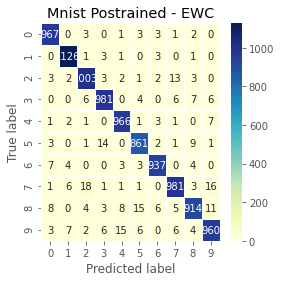

In [46]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = np.argmax(model_ewcB.predict(x_test1, y_test1, 100, 1), axis=-1)
cm = confusion_matrix(y_test1, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('Mnist Postrained - EWC')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

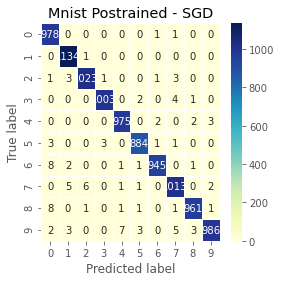

In [47]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = np.argmax( model_NoP_B.predict(x_test1, y_test1, 100, 1), axis=-1)
cm = confusion_matrix(y_test1, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('Mnist Postrained - SGD')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

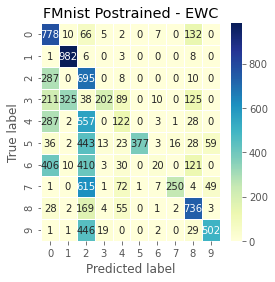

In [48]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = np.argmax(model_ewcB.predict(x_test, y_test, 100, 1), axis=-1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('FMnist Postrained - EWC')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

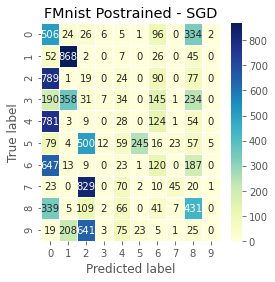

In [49]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = np.argmax( model_NoP_B.predict(x_test, y_test, 100, 1), axis=-1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (4,4))
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)
plt.title('FMnist Postrained - SGD')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()